In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [12]:
import pandas_datareader as pdr
import datetime as datetime
start = datetime.datetime(2019,1,1)
end = datetime.date.today()
stock= '1810.HK'
df = pdr.DataReader(stock, 'yahoo', start=start)
df = pd.DataFrame(df[['Open','High','Low','Close','Adj Close', 'Volume']]).reset_index()
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,12.980000,12.980000,12.180000,12.200000,12.200000,32515761
1,2019-01-03,12.280000,12.320000,11.760000,11.760000,11.760000,38910146
2,2019-01-04,11.660000,12.040000,11.500000,11.960000,11.960000,25943844
3,2019-01-07,12.320000,12.380000,11.960000,12.000000,12.000000,28376962
4,2019-01-08,12.160000,12.160000,11.060000,11.100000,11.100000,91106400
...,...,...,...,...,...,...,...
520,2021-02-09,27.250000,27.700001,27.049999,27.299999,27.299999,94000947
521,2021-02-10,27.799999,27.900000,27.200001,27.450001,27.450001,136094058
522,2021-02-11,28.000000,28.000000,28.000000,28.000000,28.000000,0
523,2021-02-16,28.450001,29.700001,28.400000,29.549999,29.549999,191211054


In [13]:
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
0,0.0,12.200000,NaN,NaN
1,0.0,11.760000,NaN,NaN
2,0.0,11.960000,NaN,NaN
3,0.0,12.000000,NaN,NaN
4,0.0,11.100000,NaN,NaN
...,...,...,...,...
520,0.0,27.299999,35.299999,24.299999
521,0.0,27.450001,35.299999,24.299999
522,0.0,28.000000,35.299999,24.299999
523,0.0,29.549999,35.299999,24.299999


In [14]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [15]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])

day 83: buy 1 units at price 10.580000, total balance 9989.420000
day 84: buy 1 units at price 10.460000, total balance 9978.960000
day 86: buy 1 units at price 10.120000, total balance 9968.840000
day 90: buy 1 units at price 9.890000, total balance 9958.950000
day 91: buy 1 units at price 9.870000, total balance 9949.080000
day 93: buy 1 units at price 9.800000, total balance 9939.280000
day 94: buy 1 units at price 9.770000, total balance 9929.509999
day 95: buy 1 units at price 9.660000, total balance 9919.849999
day 99: buy 1 units at price 9.580000, total balance 9910.270000
day 100: buy 1 units at price 9.090000, total balance 9901.179999
day 101: buy 1 units at price 9.020000, total balance 9892.159999
day 131: buy 1 units at price 9.000000, total balance 9883.159999
day 133: buy 1 units at price 8.950000, total balance 9874.209999
day 142: buy 1 units at price 8.800000, total balance 9865.409999
day 144: buy 1 units at price 8.660000, total balance 9856.749999
day 145: buy 1 u

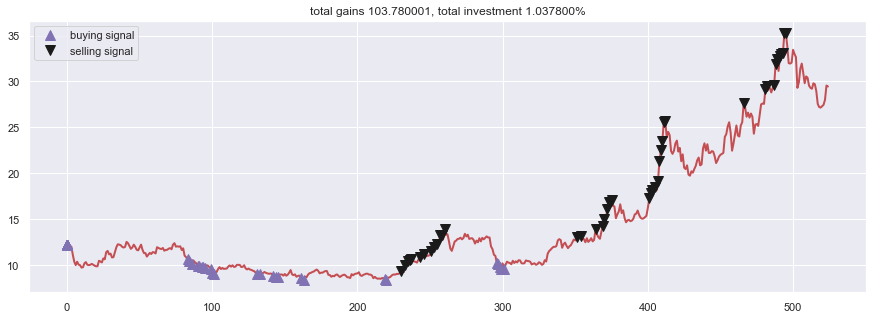

In [16]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()